In [322]:
from matplotlib.image import imread
import numpy as np
from Utility import blockproc
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from dahuffman import HuffmanCodec
import sys

# Section 1.1

In [323]:
def colortrans(rgb):
    coef_mat = np.array([[0.299, 0.587, 0.114],
                   [-0.168736, -0.331264, 0.5],
                   [0.5, -0.418688, -0.081312]])
    x,y,z = rgb.shape
    ycBcR = np.zeros([x,y,z])
    for i in range(x):
        for j in range(y):
            ycBcR[i,j,:] = np.dot(coef_mat, rgb[i,j,:].transpose())
            ycBcR[i,j,1] += 128
            ycBcR[i,j,2] += 128

            
    return ycBcR

In [324]:
def invcolortrans(ycBcR):
    coef_mat = np.array([[0.299, 0.587, 0.114],
                   [-0.168736, -0.331264, 0.5],
                   [0.5, -0.418688, -0.081312]])
    
    coef_mat_inv = np.linalg.inv(coef_mat)
#     print(coef_mat_inv)
    x,y,z = ycBcR.shape
    rgb = np.zeros([x,y,z])
    ycBcR[:,:,1] = ycBcR[:,:,1] - 128
    ycBcR[:,:,2] = ycBcR[:,:,2] - 128
    for i in range(x):
        for j in range(y):
            
            rgb[i,j,:] = np.dot(coef_mat_inv, ycBcR[i,j,:].transpose())
    
    return rgb
    

# Section 1.2

In [325]:
def downsample(mat, w=4):
    (m,n) = mat.shape
    downsample_mat = np.zeros( (int(m/w), int(n/w)), dtype=np.double )
    (a,b) = downsample_mat.shape
    
    index_x = 0
    for i in range(a):
        index_y = 0
        for j in range(b):
            avg = 0
            for k in range(w):
                avg += sum(mat[index_x+k, index_y:index_y+w])
#                 print(k)
            mean_avg = avg / (w*w)
            downsample_mat[i,j] = mean_avg
        
            if index_y < (n - 1 -w):
                index_y += w
        
        if index_x < (m - 1 - w):
            index_x += w
            
#     print(downsample_mat[0:5, 0:5])
    return downsample_mat

In [326]:
def upsample(mat, w=4):
    (m,n) = mat.shape
    upsample_mat = np.zeros( (m*w, n*w), dtype=np.double )
    (a,b) = upsample_mat.shape
    
    index_x = 0
    for i in range(m):
        index_y = 0
        for j in range(n):
            for row in range(w):
                for col in range(w):
                    upsample_mat[index_x+row, index_y+col] = mat[i,j]
            
            if index_y < (b - w -1):
                index_y += w
        if index_x < (a - w -1):
            index_x += w
            
    return upsample_mat

# Section 1.3

In [327]:
def quanmat(mat):
    q = np.array([[8, 16, 19, 22, 26, 27, 29, 34],
                [16, 16, 22, 24, 27, 29, 34, 37],
                [19, 22, 26, 27, 29, 34, 34, 38],
                [22, 22, 26, 27, 29 ,34, 37, 22],
                [22, 26, 27, 29, 32, 35, 40, 22],
                [26, 27, 29, 32, 35, 40, 48, 58],
                [26, 27, 29, 36, 38, 46, 56, 69],
                [27, 30, 35, 46, 46, 56, 69, 83]])
    
    quant_mat = np.divide(mat, q)
    quant_mat = quant_mat.astype(int)
    
    return quant_mat
    

In [328]:
def invquanmat(mat):
    q = np.array([[8, 16, 19, 22, 26, 27, 29, 34],
                [16, 16, 22, 24, 27, 29, 34, 37],
                [19, 22, 26, 27, 29, 34, 34, 38],
                [22, 22, 26, 27, 29 ,34, 37, 22],
                [22, 26, 27, 29, 32, 35, 40, 22],
                [26, 27, 29, 32, 35, 40, 48, 58],
                [26, 27, 29, 36, 38, 46, 56, 69],
                [27, 30, 35, 46, 46, 56, 69, 83]])
    
    inv_quant_mat = np.multiply(mat, q)
#     inv_quant_mat = inv_quant_mat.astype(int)
    
    return inv_quant_mat

# Section 1.4

In [331]:
def dct_2d(mat):
    return dct(dct(mat.T, norm='ortho').T, norm='ortho')

In [332]:
def idct_2d(mat):
    return idct(idct(mat.T, norm='ortho').T, norm='ortho')

In [333]:
def dct_quant(mat,b):
    
    # Applying DCT
    dct_mat = blockproc(mat, b, dct_2d)
    # Applying Quantization
    dct_quant_mat = blockproc(dct_mat, b, quanmat)
    
    return dct_quant_mat
    

In [334]:
def idct_quant(mat, b):
    # Applying inverse quantization
    iquant_mat = blockproc(mat, b, invquanmat)
    # Applying iDCT
    idct_iquant_mat = blockproc(iquant_mat, b, idct_2d)
    
    return idct_iquant_mat

# Fuction calling for 1.4

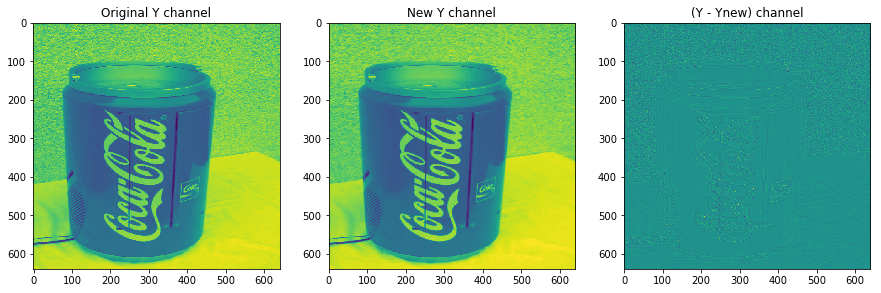

In [335]:
img = imread('cola.jpg')
b = (8,8)

YcBcR = colortrans(img)
y = YcBcR[:,:,0]
cb = YcBcR[:,:,1]
cr = YcBcR[:,:,2]

# downsampling
ds_cb = downsample(cb)
ds_cr = downsample(cr)

# Applying DCT & Quantization
y_app = dct_quant(y, b)
cb_app = dct_quant(ds_cb, b)
cr_app = dct_quant(ds_cr, b)

# Applying iDCT & Quantization
y_new = idct_quant(y_app, b)
cb_new = idct_quant(cb_app, b)
cr_new = idct_quant(cr_app, b)


fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('Original Y channel')
ax1.imshow(y)

ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('New Y channel')
ax2.imshow(y_new)

ax3 = fig.add_subplot(1,3,3)
ax3.title.set_text('(Y - Ynew) channel')
ax3.imshow(y-y_new)


Observation: 
    1. We observed no significant difference between the Original Y channel and the newY. Although newY channel image looks slightly smoother than the previous, may be because of the rounding of the values in the quantization step.
    2. We bought down values for all three channels into interger by rounding off in the process of quantization, which leaves many values to have same number. This will save space, we will have less different values for compression. 
    3. Yes, we lose little bit of quality because of rounding the values and storing as intergers. we can observe in the the 3rd image that of difference of two Ys, that we loose few details from the original ones

# Section 1.5

In [336]:
def encodemat(mat, codec):
    
    flatten_mat = mat.flatten()
    encoded = codec.encode(flatten_mat)
    return encoded

In [337]:
def decodemat(encoded, codec, row, col):
    
    decoded = codec.decode(encoded)
    decoded = np.reshape(decoded, (row,col))
    return decoded

In [338]:
y_app_flatten = y_app.flatten()
y_codec = HuffmanCodec.from_data(y_app_flatten)
(y_row, y_col) = y_app.shape

cb_app_flatten = cb_app.flatten()
cb_codec = HuffmanCodec.from_data(cb_app_flatten)
(cb_row, cb_col) = cb_app.shape

cr_app_flatten = cr_app.flatten()
cr_codec = HuffmanCodec.from_data(cr_app_flatten)
(cr_row, cr_col) = cr_app.shape


In [339]:
y_compressed = encodemat(y_app, y_codec)
print("Encoded length for y':",sys.getsizeof(y_compressed), "bytes and Original length for y':", sys.getsizeof(y_app_flatten), "bytes")
cb_compressed = encodemat(cb_app, cb_codec)
print("Encoded length for Cb':",sys.getsizeof(cb_compressed), "bytes and Original length for Cb':", sys.getsizeof(cb_app_flatten), "bytes")

cr_compressed = encodemat(cr_app, cr_codec)
print("Encoded length for Cr':",sys.getsizeof(cr_compressed), "bytes and Original length for Cr':", sys.getsizeof(cr_app_flatten), "bytes")


Encoded length for y': 66816 bytes and Original length for y': 3276896 bytes
Encoded length for Cb': 3616 bytes and Original length for Cb': 204896 bytes
Encoded length for Cr': 3981 bytes and Original length for Cr': 204896 bytes


Lengths of Encoded channels:

Y = 66816 bytes, Cb = 3616 bytes, Cr = 3981 bytes

# Section 1.6

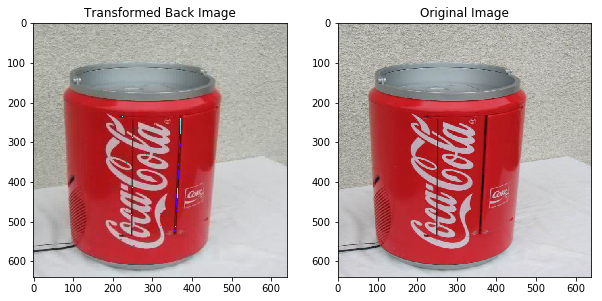

In [340]:
# Getting back the image

# decoding from Huffan coding
y_decompressed = decodemat(y_compressed, y_codec, y_row, y_col)
cb_decompressed = decodemat(cb_compressed, cb_codec, cb_row, cb_col)
cr_decompressed = decodemat(cr_compressed, cr_codec, cr_row, cr_col)

# Applying Inverse DCT and quantasition
y_idct = idct_quant(y_decompressed, b)
cb_idct = idct_quant(cb_decompressed, b)
cr_idct = idct_quant(cr_decompressed, b)

# Upsampling Cb, Cr channel
cb_up = upsample(cb_idct, 4)
cr_up = upsample(cr_idct, 4)

new_YcBcR = np.zeros([640, 640, 3])
new_YcBcR[:,:,0] = y_idct
new_YcBcR[:,:,1] = cb_up
new_YcBcR[:,:,2] = cr_up

new_rgb = invcolortrans(new_YcBcR)
new_rgb = new_rgb.astype(np.uint8)
# plt.imshow(new_rgb.astype(np.uint8))

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax1.title.set_text('Transformed Back Image')
ax1.imshow(new_rgb)

ax2 = fig.add_subplot(1,2,2)
ax2.title.set_text('Original Image')
ax2.imshow(img)



The quality reduced during the compression because we downsampled the Cb and Cr chroma channels before compression. So, we loose the actual values for some pixels when we upsampled them back. But it doesn't have much effect as we retained the most important information, the values of luminance channel y.